In [25]:
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Config

In [13]:
TRAINING_DATA_PATH = './TargetData-TF-Train.csv'
VALIDATION_DATA_PATH = './TargetData-TF-Valid.csv'
VALIDATION_DATA_PREDICTION_PATH = './TargetData-TF-Valid-PredictionORB.csv'
TEST_DATA_PATH = './TargetData-TF-Test.csv'

IMAGE_FOLDER_PATH = './TargetImages-TF/'

TARGET_CLASSES_MAPPING = {}
TARGET_CLASSES_MAPPING[10419] = 'Qutub Minar'
TARGET_CLASSES_MAPPING[47378] = 'Eiffel Tower'
TARGET_CLASSES_MAPPING[168098] = 'Golden Gate Bridge'
TARGET_CLASSES_MAPPING[162833] = 'Pakistan Monument'
TARGET_CLASSES_MAPPING[1924] = 'Niagara River'

## Dataset

In [27]:
def drawKeyPts(grayImage, keyp):
    
    out_im = (grayImage * 255).astype(np.uint8)
    out_im = np.concatenate((out_im[:,:,np.newaxis], 
                             out_im[:,:,np.newaxis], 
                             out_im[:,:,np.newaxis]), axis=2)
    
    for curKey in keyp:
        x=np.int32(curKey.pt[0])
        y=np.int32(curKey.pt[1])
        size = np.int32(curKey.size)
        cv2.circle(out_im, (x,y), 8, [255, 0, 0], 
                   thickness=1, lineType=8, shift=0)

    return out_im

def HarrisKeypointDetector(in_image, n=2, w=3, k=0.04, verbose=True):
    
    harrisImage = cv2.cornerHarris(in_image, n, w, k)
    thresh = 0.1 * harrisImage.max()
    harrisMaxImage = harrisImage > thresh
    
    height, width = in_image.shape[:2]
    features = []
    for y in range(height):
        for x in range(width):
            
            if not harrisMaxImage[y, x]:
                continue

            f = cv2.KeyPoint()
            f.pt = (x, y)
            f.response = harrisImage[y,x]
            features.append(f)
            
            
    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
        ax[0].imshow(drawKeyPts(in_image, features)); ax[0].axis('off')
        ax[0].set_title('image')
        har_im = ax[1].imshow(harrisImage, cmap='gray'); ax[1].axis('off')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(har_im, cax=cax)
        ax[1].set_title('score')
        plt.suptitle('KEYPOINTS')
        plt.show()
           
    return features

def read_image(in_path):

    img = plt.imread(in_path)
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0
    
    if len(img.shape) > 2:
        img = img[:, :, 2].copy()
        
    return img


def ORBFeatureDescriptor(grayImage, keypoints):
    orb = cv2.ORB_create()
    kp, des = orb.compute((grayImage * 255).astype(np.uint8), keypoints)
    return des


def load_data(filename):
    df = pd.read_csv(filename)
    
    id_mapping = {}
    id_des = {}
    
    
    for index in range(len(df)):
        image_id = df['id'][index]
        image_label = df['landmark_id'][index]
        
        if index % 25 == 0:
            print(f'Read {index} images')
            
        id_mapping[image_id] = image_label
        image_path = os.path.join(IMAGE_FOLDER_PATH, image_id + '.jpg')
        image = read_image(image_path)        
        
        kp = HarrisKeypointDetector(image, n=2)        
        des = ORBFeatureDescriptor(image, kp)
        
        id_des[image_id] = des
        
    return id_mapping, id_des

In [15]:
train_id_mapping, train_id_des = load_data(TRAINING_DATA_PATH)

Read 0 images
Read 25 images
Read 50 images
Read 75 images
Read 100 images
Read 125 images
Read 150 images
Read 175 images
Read 200 images
Read 225 images


In [16]:
valid_id_mapping, valid_id_des = load_data(VALIDATION_DATA_PATH)

Read 0 images
Read 25 images
Read 50 images
Read 75 images
Read 100 images


In [17]:
def feature_matching(desc1, desc2):
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    return len(good)

def tf_predictor(reference_id_mapping, reference_id_des, sample_des):
    
    good_matches = {}
    for key,values in TARGET_CLASSES_MAPPING.items():
        good_matches[key] = 0
        
    gm_count = 0
    max_gm_count = 0
    max_gm_label = -1
    max_gm_reference = ''
    for image_id, image_label in reference_id_mapping.items():
        
        gm_count = feature_matching(reference_id_des[image_id], sample_des)
        
        good_matches[image_label] += gm_count
        
        if gm_count > max_gm_count:
            max_gm_count = gm_count
            max_gm_label = image_label
            max_gm_reference = image_id            
        
        
    max_agg_matches = 0
    max_agg_label = -1
    for image_label, good_match_count in  good_matches.items():
        if good_match_count > max_agg_matches:
            max_agg_matches = good_match_count
            max_agg_label = image_label            
    
    return max_agg_label, max_gm_label, max_gm_reference

## Prediction

In [18]:
df_valid = pd.read_csv(VALIDATION_DATA_PATH)
df_valid['prediction_agg'] = 'Missing Prediction'
df_valid['prediction_max'] = 'Missing Prediction'
df_valid['prediction_max_ref'] = 'Missing Prediction'

total_test_correct_agg = 0
total_test_correct_max = 0
index = 0

for index in range(len(df_valid)):
    image_id = df_valid['id'][index]
    image_label = df_valid['landmark_id'][index]
    
    max_agg_label, max_gm_label, max_gm_reference= tf_predictor(
        train_id_mapping, train_id_des, valid_id_des[image_id])
    
    
    if image_label == max_agg_label:
        total_test_correct_agg += 1
    
    if image_label == max_gm_label:
        total_test_correct_max += 1
        
    
    df_valid['prediction_agg'][index] = max_agg_label
    df_valid['prediction_max'][index] = max_gm_label
    df_valid['prediction_max_ref'][index] = max_gm_reference

    if index % 10 == 0:
        print(f'Total Images: {index + 1}, Correct Agg Count: {total_test_correct_agg}, Correct Max Count: {total_test_correct_max}')



C:\Users\vibhatna.FAREAST\AppData\Local\Temp\ipykernel_33908\1809165047.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['prediction_agg'][index] = max_agg_label
C:\Users\vibhatna.FAREAST\AppData\Local\Temp\ipykernel_33908\1809165047.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['prediction_max'][index] = max_gm_label
C:\Users\vibhatna.FAREAST\AppData\Local\Temp\ipykernel_33908\1809165047.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Total Images: 1, Correct Agg Count: 0, Correct Max Count: 0
Total Images: 11, Correct Agg Count: 2, Correct Max Count: 3
Total Images: 21, Correct Agg Count: 5, Correct Max Count: 5
Total Images: 31, Correct Agg Count: 6, Correct Max Count: 7
Total Images: 41, Correct Agg Count: 7, Correct Max Count: 10
Total Images: 51, Correct Agg Count: 12, Correct Max Count: 16
Total Images: 61, Correct Agg Count: 13, Correct Max Count: 18
Total Images: 71, Correct Agg Count: 18, Correct Max Count: 23
Total Images: 81, Correct Agg Count: 19, Correct Max Count: 24
Total Images: 91, Correct Agg Count: 21, Correct Max Count: 26
Total Images: 101, Correct Agg Count: 25, Correct Max Count: 30
Total Images: 111, Correct Agg Count: 28, Correct Max Count: 32
Total Images: 121, Correct Agg Count: 31, Correct Max Count: 36


In [19]:
print(f'Total Images: {index + 1}, Correct Agg Count: {total_test_correct_agg}, Correct Max Count: {total_test_correct_max}')
df_valid.to_csv(VALIDATION_DATA_PREDICTION_PATH, sep=',')

Total Images: 125, Correct Agg Count: 32, Correct Max Count: 36


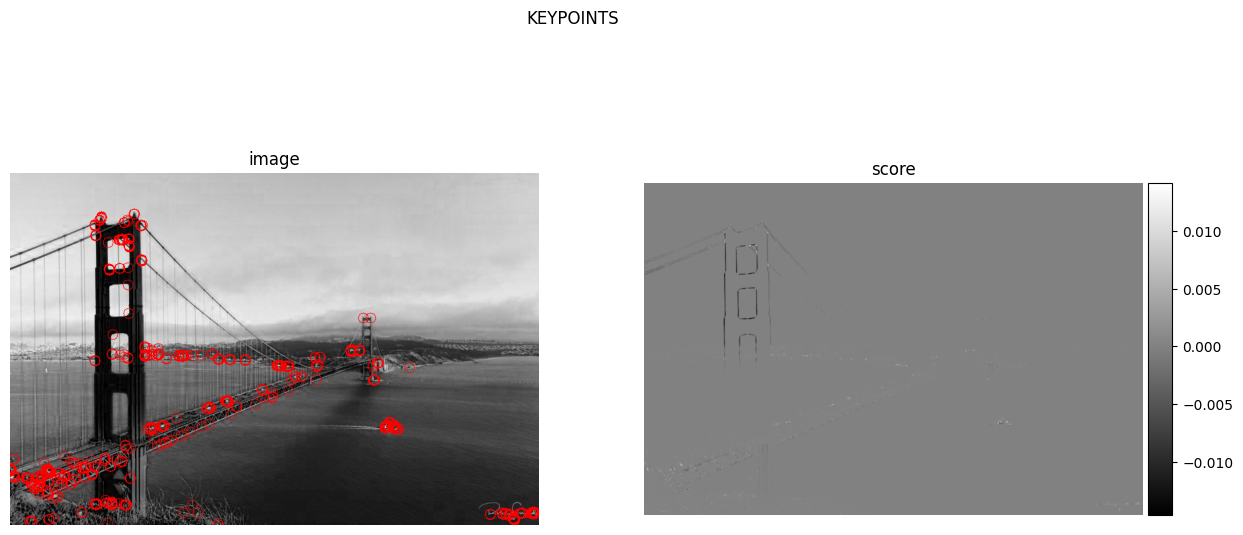

In [28]:
image_path = 'C:/W281-Project/Notebook/TargetImages-TF/0ef826f65ce873b3.jpg'
image = read_image(image_path)
features = HarrisKeypointDetector(image, n=2, w=3, k=0.04, verbose=True)